# Pipeline

1. Maak SQL scripts voor schema's: RAW, ARCHIVED, CLEANSED -finished
2. Importeer source data in RAW -finished
3. Data cleaning => RAW naar ARCHIVED en CLEANSED -finished
4. Maak SQL scripts voor Data Warehouse / Ster schema
5. Import van CLEANSED naar DWH - finished
6. Prep Data lake: export tabellen naar Parquet files - finished
7. Upload Parquet files naar S3 (eerst bucket aanmaken) - finished
8. Maak Athena tables
9. Gebruik Athena in BI tool naar keuze

In [211]:
%pip install -q pandas sqlalchemy psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


## BI TOOL

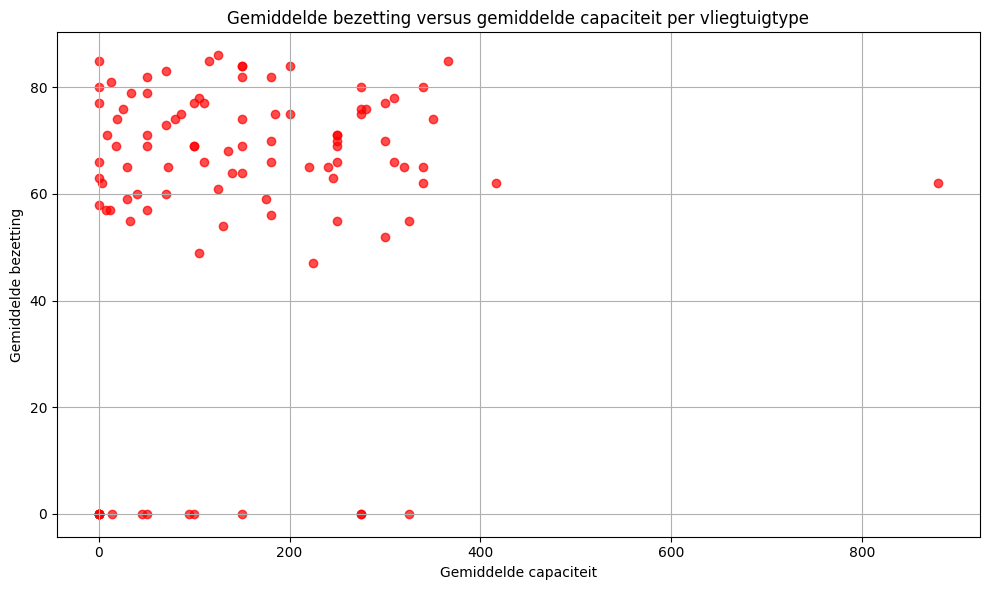

In [11]:
from pyathena import connect
import pandas as pd
import matplotlib.pyplot as plt
from pyathena.pandas.cursor import PandasCursor

cursor = connect(s3_staging_dir="s3://bucket-data-engeneering-project-nick/Unsaved/2024/05/25/",
                 region_name="us-east-1",
                 cursor_class=PandasCursor).cursor()

# querry om gemiddelde bezetting van vluchten per maatschappij te bekijken
query_bezetting = """
SELECT v.vliegtuigtype_naam, 
       AVG(f.bezetting) AS gemiddelde_bezetting,
       AVG(v.capaciteit) AS gemiddelde_capaciteit
FROM 
    "data-engeneering-project-db".vluchten_feit_parquet f
JOIN "data-engeneering-project-db".vliegtuig_dim_parquet v ON f.vliegtuig_code = v.vliegtuig_code
GROUP BY v.vliegtuigtype_naam
"""

# Gegevens ophalen van Athena
data_bezetting = cursor.execute(query_bezetting).as_pandas()

# Visualisatie - Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(data_bezetting['gemiddelde_capaciteit'], data_bezetting['gemiddelde_bezetting'], c='red', alpha=0.7)
plt.xlabel('Gemiddelde capaciteit')
plt.ylabel('Gemiddelde bezetting')
plt.title('Gemiddelde bezetting versus gemiddelde capaciteit per vliegtuigtype')
plt.grid(True)
plt.tight_layout()
plt.show()

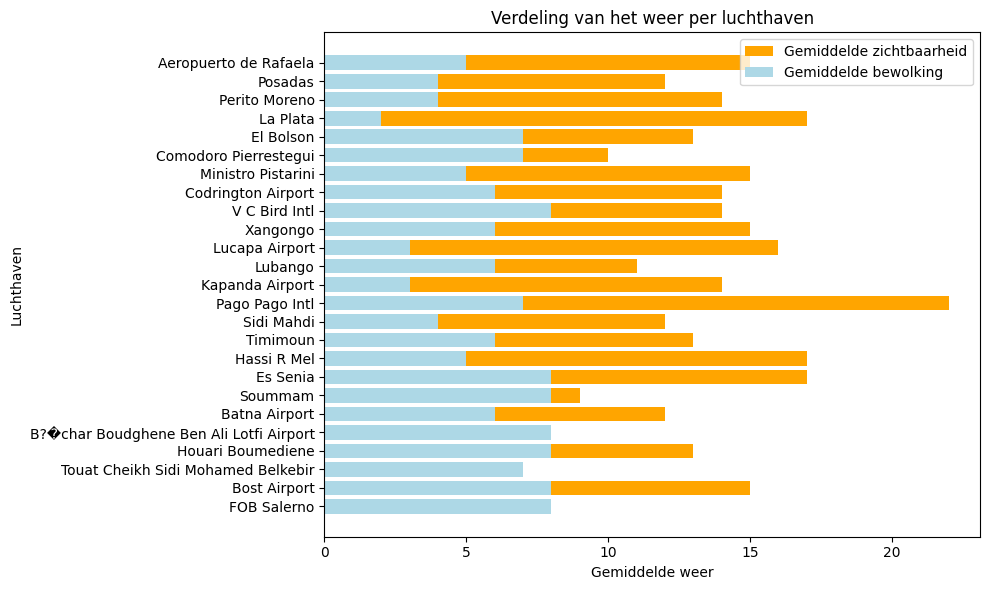

In [16]:
# Voorbeeldquery om de gemiddelde bewolking en gemiddelde zichtbaarheid per luchthaven op te halen
query_weer = """
SELECT l.luchthaven_naam, 
       AVG(w.gemiddelde_bewolking) AS gemiddelde_bewolking,
       AVG(w.gemiddelde_zichtbaarheid) AS gemiddelde_zichtbaarheid
FROM "data-engeneering-project-db".luchthavens_dim_parquet l
JOIN "data-engeneering-project-db".weer_dim_parquet w ON l.luchthaven_id = w.weer_id
GROUP BY l.luchthaven_naam
LIMIT 25
"""

# Gegevens ophalen van Athena
data_weer = cursor.execute(query_weer).as_pandas()

# Visualisatie - Horizontale gestapelde staafdiagram
plt.figure(figsize=(10, 6))
plt.barh(data_weer['luchthaven_naam'], data_weer['gemiddelde_zichtbaarheid'], color='orange', label='Gemiddelde zichtbaarheid')
plt.barh(data_weer['luchthaven_naam'], data_weer['gemiddelde_bewolking'], color='lightblue', label='Gemiddelde bewolking')
plt.xlabel('Gemiddelde weer')
plt.ylabel('Luchthaven')
plt.title('Verdeling van het weer per luchthaven')
plt.legend()
plt.tight_layout()
plt.show()